# Accelerated Primal Dual to solve Discrete Optimal Transport

<div class="alert alert-block alert-success">
    
This notebook we aim at solving DOT instances using modern optimisation algorithms that outperform the simplex method. To do this we will use the Primal Dual framework. 
    
The notebook is divided in three parts. First, Condat's projection into the ℓ<sub>1</sub> ball algorithm is implemented. Second, the algorithm is used to find feasible solutions of DOT. Finally, the Primal Dual algorithm is tested. The results are automatically stored with an unique identifier and some performance plots are presented.
</div>

* Laurent Condat. <i>Fast projection onto the simplex and the ℓ<sub>1</sub> ball</i>. Math. Program. 158, 575–585 (2016). [https://doi.org/10.1007/s10107-015-0946-6](https://doi.org/10.1007/s10107-015-0946-6). _Also available at_ [https://hal.archives-ouvertes.fr/hal-01056171v2](https://hal.archives-ouvertes.fr/hal-01056171v2).



* V ̃u, B. (2011). <i>A splitting algorithm for dual monotone inclusions involving cocoercive operators </i>. Adv. Comput. Math, pages 667–681. [https://doi.org/10.1007/s10444-011-9254-8](https://doi.org/10.1007/s10444-011-9254-8).

<div class="alert alert-block alert-info">
Packages
</div>

In [1]:
import numpy  as np
import pandas as pd
import time
import os
import matplotlib.pyplot as plt

# Particular functions
from numpy import zeros, zeros_like, allclose, where, ones, inf, absolute, linspace, maximum, minimum
from numpy import asarray, add, subtract, multiply
from numpy.random import default_rng as rng
from numba import jit
from scipy.spatial.distance import cdist
from scipy.linalg import norm
from numpy.polynomial.chebyshev import chebpts1

# Algorithm

Now, we will run the Primal Dual algorithm addapted for DOT. To test it, we will run it against some of the DOTMark files. We will aim to transport from one given image to another, which are normalised and flattened in ```C```-order. The matrix of costs is based on a uniform grid within $[0,1]^2$ with $M$ points for the source and $N$ points for the target.

## Instance information

In [2]:
folder = 'Microscopy_Sized'
path = 'Exact/' + folder + '/'

In [3]:
files = [f[:-9] for f in os.listdir(path) if f.endswith('.txt')]
print('There are', len(files), 'instances in this location:')
display(files)

There are 4 instances in this location:


['data16_1002-data16_1010_p=S2',
 'data8_1002-data8_1010_p=S2',
 'data32_1002-data32_1010_p=S2',
 'data64_1002-data64_1010_p=S2']

Select one instance:

In [4]:
instance = files[1]
full_path = path + instance

Load data:

In [5]:
m = np.load(full_path + '_m.npy');    M = m.size
n = np.load(full_path + '_n.npy');    N = n.size
c = np.load(full_path + '_Cost.npy')
sol = np.load(full_path + '_Sol.npy')

In [6]:
with open(full_path + '_Time.txt', 'r') as f:
    obj_exact = eval((f.readlines())[0])['Obj']

## Run algorithm

<div class="alert alert-block alert-warning">
    
In what follows, we provide tests for the chosen instance running the Primal Dual approach given by Bằng Công Vũ (2011) in its linesearch version as in Malitsky and Pock (2018). The projection operator is based on the one presented in Mai et al (2021).
    
    
* Bằng Công Vũ (2011). <i>A splitting algorithm for dual monotone inclusions involving cocoercive operators</i>. Adv. Comput. Math, pp 667–681. [https://doi.org/10.1007/s10444-011-9254-8](https://doi.org/10.1007/s10444-011-9254-8).
    
* Vien V. Mai, Jacob Lindbäck, Mikael Johansson. (2021). <i>A Fast and Accurate Splitting Method for Optimal Transport: Analysis and Implementation</i>. arXiV preprint. [https://doi.org/10.48550/arXiv.2110.11738](https://doi.org/10.48550/arXiv.2110.11738).
    
* Yura Malitsky and Thomas Pock. (2018). <i>A first-order primal-dual algorithm with linesearch</i>. SIAM Journal on Optimization, pp 411–432. [https://doi.org/10.1137/16M1092015](https://doi.org/10.1137/16M1092015).
</div>

Let $\mathcal{X}$ be the following set of real-valued matrices with prescribed row and column sums; i.e.,
$
    \mathcal{X} := 
    \big\{
        u \in \mathbb{R}^{M\times N}:\,   u \mathbb{1}_N = m 
        \,\,\text{ and }\,\,
        \mathbb{1}_M u = n
    \big\}
$;
where $\mathbb{1}_s$ is a vector of ones of size $s$.

## First choice of funcions

In the framework of Malitsky and Pock (2018), we will identify $f(x) = 1:x + \imath_{\mathbb{R}_{\geq 0}}(x)$, $g = \imath_{\mathcal{X}}$, and $K=c$.

**Here the choice of $f$ might not be the proper one, since $\imath_{\mathbb{R}_{\geq 0}}(c:x)$ may not be necessarily equal to $\imath_{\mathbb{R}_{\geq 0}}(x)$. We will analyse what changes are needed to guarantee this.**

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Primal Dual Algorithm with Linesearch</h2>
<ol>
<li>Set $\tau_0,\beta >0$, $\mu,\delta \in (0,1)$
<li>Set $\theta_0 = 1$</li>
<li>For $k \in \{1,\ldots, K\}$, do
<ol>
<li>$x_k = \mathrm{prox}_{\tau_{k-1} g} \big( x_{k-1} - \tau_{k-1} c y_k \big)$
<li>Choose $\tau_k \in [\tau_{k-1}, \tau_{k-1}\sqrt{1+\theta}]$
<div style="color: #088A68;">
// Linesearch //
</div>
    <ol>
    <li> $\theta_k = {\tau_k} \big/ {\tau_{k-1}}$
    <li> $\bar{x} = x_k + \theta_k (x_k - x_{k-1})$
    <li> $y_{k+1} = \mathrm{prox}_{ \beta\tau_k f^*} (y_k + \beta\tau_k c \bar{x}_k)$
    <li> Break linesearch if $ \sqrt{\beta} \tau_k \| c(y_{k+1}-y_k) \| \leq \delta \| y_{k+1}-y_k \| $, else $\tau_k = \mu \tau_k$
    </ol>
</div>

Now, the proximal of $g$ is the projection on $\mathcal{X}$, which is of the form $\mathrm{proj}_{\mathcal{X}}(u) = u - G(u)$, where $G$ is known. Thus, step 3A is easy to compute. 

On the other hand, we have that the extended Moreau decomposition allows us to write
\begin{align}
    \mathrm{prox}_{\sigma f^*}(u) = u - \sigma \mathrm{prox}_{ \sigma^{-1} f } \big( \sigma^{-1} u \big).
\end{align}
Now, the proximity operator of $\eta f$ is just $\mathrm{prox}_{\eta f} (u) = [ u - \eta ]_+$. As a result, we have that
\begin{align}
    \mathrm{prox}_{\sigma f^*}(u) = u - \sigma [\sigma^{-1} u - \sigma^{-1} ]_+.
\end{align}
However, we know that $[u]_+ = \max\{u,0\} = \frac{1}{2} (u + |u|)$. In this setting we have that
\begin{align}
    \sigma [\sigma^{-1} u - \sigma^{-1} ]_+ = \frac{\sigma}{2} \big( \sigma^{-1}(u-1) + \sigma^{-1} |u-1|\big) = [u-1]_+.
\end{align}
On the other hand, we also have that $[u]_- = \min\{u,0\} = \frac{1}{2} (u - |u|)$. Hence we arrive at
\begin{align}
    \mathrm{prox}_{\sigma f^*}(u) = u - [u-1]_+ = (u-1) - \frac{1}{2} \big( (u-1) + |u-1|\big) + 1 = \frac{1}{2} \big( (u-1) - |u-1|\big) + 1 = [u-1]_- + 1.
\end{align}

We can now explicitly write each step of the algorithm:

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Primal Dual Algorithm with Linesearch</h2>
<ol>
<li>Set $\tau_0,\beta >0$, $\mu,\delta \in (0,1)$
<li>Set $\theta_0 = 1$</li>
<li>For $k \in \{1,\ldots, K\}$, do
<ol>
<li>$u_k = x_{k-1} - \tau_{k-1} c y_k$
<div style="color: #088A68;">
// Projection onto the set of real-valued matrices with prescribed row and column sums //
</div>
<li>$\kappa_1 = u_k\mathbb{1}_{N} - m$
<li>$\beta_1 = \langle \kappa_1, \mathbb{1}_M \rangle \big/ (M+N)$
<li>$\kappa_2 = \mathbb{1}_{M}u_k - n$
<li>$\beta_2 = \langle \kappa_2, \mathbb{1}_N \rangle \big/ (M+N)$
<li>$q_k = \sigma \big( \frac{1}{N}(\kappa_1 - \beta_1)\mathbb{1}_{N}^\top + \frac{1}{M} \mathbb{1}_{M}( \kappa_2 - \beta_2 )^\top \big) $
<li>$x_k = u_k - q_k$
<li>Choose $\tau_k \in [\tau_{k-1}, \tau_{k-1}\sqrt{1+\theta}]$
<div style="color: #088A68;">
// Linesearch //
</div>
    <ol>
    <li> $\theta_k = {\tau_k} \big/ {\tau_{k-1}}$
    <li> $\bar{x} = x_k + \theta_k (x_k - x_{k-1})$
    <li> $y_{k+1} = [y_k + \beta\tau_k c x_k - 1]_- + 1$
    <li> Break linesearch if $ \sqrt{\beta} \tau_k \| c(y_{k+1}-y_k) \| \leq \delta \| y_{k+1}-y_k \| $, else $\tau_k = \mu \tau_k$
    </ol>
</div>

Observe that the inequality $x\geq 0$ is only satisfied for $f(Kx)$ if and only if $c_{i,j} > 0$ component-wise. In the current instance, we have a cost that is zero on diagonal elements (since we want to move mass on the same grid). As a result, the algorithm may not work as we expect. We could do the following fix: We take $\tilde{c} = c + \varepsilon$ and optimise the new cost functional (which would only have an offset in the objective value but the implication would hold while preserving the minimiser of the original problem).

If we take this strategy, the optimal cost is given by $\tilde{c}:x^* = c:x^* + \varepsilon$.

In [345]:
def accelerated_primal_dual(c,m,n,iters, collect_obj = False, true_obj = None, 
                         true_obj_tol = 1e-4, true_solution = None, save_iter = False, 
                         guess_x = None,  guess_y = None, show = False,
                         τ = 1e-3 * 1.9, σ = 1.0/(1e-3 * 1.9) - 1e-5, δ = 0.99, μ = 0.7, λ = 0.5, β = None):
    # Algorithm for calculating solution x, in the primal space
    # and y = [ψ, ϕ] in the dual space.
    # Also returns the value of the objective function c*x at each
    # iteration.
    # μ = 0.7, δ = 0.99, τ0 = \sqrt{ \min\{m,n\} }, β = 1/400, = σ/τ [PDAL]
    # μ, δ in (0,1)^2
    
    '''
        Initialise parameters
    '''
    
    # Fetch lengths of m and n
    N = n.size
    M = m.size
    
    #Initialise β
    if β is None:
        β  = σ/τ                       # Primal stepsize is updated
    sβ = β**0.5
    
    # Base parameters
    #τ = (min(M,N))**0.5            # Initial step from paper
    τₖ = 0.0                       # Updated step
    
    #Initialise θ
    θ = 1.0
    

    if show:
        print('\n*** Primal Dual with M = {}, N = {}, MN = {} ***\n\n'.format(M,N,M*N))
    
    
    '''
        Initialise matrices
    '''
    # Initialise x & y
    if guess_x is not None:
        x = guess_x.copy()
    elif guess_y is not None:
        y = y.copy()
    else:
        x,y = zeros((2,M,N));
        
    # Initialise p, y, u, κ
    κₘ, yₘ = zeros((2,M))
    κₙ, yₙ = zeros((2,N))
    p, u = ones((2,M,N));
    # Initialise previous copy of x
    xₚ = x.copy()
        
    '''
        Information from true solution (if available)
    '''
    # Store current objective value
    if collect_obj == True:
        obj = [ (c*x).sum() ]
    
    # Norm of true solution
    if true_solution is not None:
        true_obj_crit = 1.0
        if true_obj is None:
            true_obj = (c*sol).sum()
        if show:
            print('Objective from ground truth:', obj_exact,'\n')
            
        
    '''
        Iterate the Primal Dual scheme
    '''
    every_iter = {
        'it':[], 'obj':[], 'dist_obj':[], 'time':[], 'dist_x':[], 'rel_var':[], 'l_1':[],
        'hyperₘ':{'L2': [], 'max': [], 'min':[]}, 'hyperₙ':{'L2': [], 'max': [], 'min':[]}
                 }
    every_critical = {'it':[], 'obj':[], 'tol':[], 'dist_obj':[], 'time':[], 'dist_x':[], 'l_1':[]}
    
    if true_solution is not None:
        if show:
            print('     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  ')
            print( '{:-^66}'.format('') )
        
    timed = 0.0
    
    
    for k in range(iters):
        it_time = time.time()
        
        # ** Dual step ** # g = ι_\_C 
        # p = x - τ * c * y
        multiply(c,y, out=p);    p *= τ
        subtract(x, p, out=p)
        
        
        # Projection step for g
        κₘ = p.sum(1) - m  # κ_1
        κₙ = p.sum(0) - n  # κ_2

        βₘ = κₘ.sum() / (M + N)        # dim M   β_1
        βₙ = κₙ.sum() / (M + N)        # dim N   β_2
        
        
        # Implicit yₖ = ( (κₘ - βₘ)/N).reshape(M,1) + (κₙ - βₙ)/M
        ψ = (1.0/N) * (κₘ - βₘ)
        ϕ = (1.0/M) * (κₙ - βₙ)
        
        # Projection: p = p - yₖ
        subtract(p, ϕ, out=p);     subtract(p, ψ.reshape(M,1), out=p)
        
        
        # Select extreme
        #τₖ = τ * (1 + θ)**0.5                # From paper
        #τₖ = 0.5 * τ * (1 + (1 + θ)**0.5)    # From Pete
        τₖ = τ * (λ + (1-λ) * (1 + θ)**0.5 )
        
        # Primal step:    f = Id + ι_ℝ≥0
        while True:
            
            θ = τₖ/τ
            
            x̄ = p + θ*(p - x)
            
            ỹ  = y + (β * τₖ) * c * x̄
            yₙ = minimum(ỹ-1,0) + 1
            
            #print('F', sβ * τₖ * norm(c*(yₙ - y),'fro'), δ * norm(yₙ-y,'fro'))
            #print('S',sβ * τₖ * norm(c*(yₙ - y)), δ * norm(yₙ-y))
            
            if (sβ * τₖ * norm(c*(yₙ - y)) < δ * norm(yₙ-y)):
                break
            # Else: reduce step size
            τₖ *= μ
        
        τ = τₖ
        x = p.copy()
        y = yₙ
        
        
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time
        
        # Recover values from mask
        ℓ_1 = norm(x.ravel(),1)
        
        # Update objective function
        if collect_obj == True:
            obj.append( (c*x).sum() )
            # Compute relative objective distance
            if true_solution is not None:
                dist_true_sol = abs(obj[-1] - true_obj)/true_obj
                
                
        # If all iterations are to be stored:
        if save_iter == True:
            frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
            r, s   = x.sum(1) - m, x.sum(0) - n
            
            every_iter['it'].append( k )
            every_iter['obj'].append( (c*x).sum() )
            every_iter['dist_obj'].append( dist_true_sol if true_obj is not None else np.nan )
            every_iter['time'].append( timed )
            every_iter['dist_x'].append( frob_d )
            every_iter['rel_var'].append( norm(xₚ-x, 'fro')/norm(x, 'fro') if not allclose(x,0) else np.nan )
            every_iter['l_1'].append(ℓ_1)
            # Constrained satisfactibility
            every_iter['hyperₘ']['L2'].append( norm(r)/norm(m) )
            every_iter['hyperₘ']['max'].append( abs(r/maximum(m,1e-7)).max() )
            every_iter['hyperₘ']['min'].append( abs(r/maximum(m,1e-7)).min() )
            every_iter['hyperₙ']['L2'].append( norm(s)/norm(n) )
            every_iter['hyperₙ']['max'].append( abs(s/maximum(n,1e-7)).max() )
            every_iter['hyperₙ']['min'].append( abs(s/maximum(n,1e-7)).min() )
            
        # If a true solution is available, we check the tolerance:
        if true_solution is not None: 
            if dist_true_sol < true_obj_crit:
                frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
                
                every_critical['it'].append( k )
                every_critical['obj'].append( obj[-1] )
                every_critical['tol'].append( true_obj_crit )
                every_critical['dist_obj'].append( dist_true_sol )
                every_critical['time'].append( timed )
                every_critical['dist_x'].append( frob_d )
                every_critical['l_1'].append(ℓ_1)

                if show:
                    print('* {0:6.0f} |   {1:.1e} |  {2:1.1e}  | {3:8.2f} s |   {4:4.4f} |  {5:4.4f}'.format(k,
                                                                            true_obj_crit,
                                                                            dist_true_sol,
                                                                            timed,frob_d,ℓ_1))
                
                # If the prescribed tolerance is reached, we finish.
                if dist_true_sol < true_obj_tol:
                    if show:
                        print('Solution found with given tolerance.')
                    break
                
                # Adjust current level of inner tolerance
                true_obj_crit *= 0.1
        
        # Update previous step
        xₚ = x.copy()
    
    if true_solution is not None:
        if show:
            print( '{:-^66}'.format('') )

    if show:
        print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(timed,k))
    
    #y = asarray([ψ, ϕ],dtype='object')
    
    if collect_obj == False and save_iter == True:
        return x, y, every_iter
    if collect_obj == True and save_iter == True:
        return x, y, obj, every_critical, every_iter
    else:
        return x

Let us compare the two strategies:

In [346]:
x, y, obj, every_critical, every_iter = accelerated_primal_dual(c,m,n, 3051, collect_obj = True, 
                                                             true_obj = obj_exact, true_obj_tol = 1e-7, 
                                                             true_solution = sol, save_iter = True, 
                                                                show = True, δ=0.9, μ=0.9)


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*     22 |   1.0e+00 |  9.7e-01  |     0.01 s |   0.8952 |  1.4490
*     43 |   1.0e-01 |  2.4e-02  |     0.02 s |   0.8421 |  1.5711
*     57 |   1.0e-02 |  1.7e-03  |     0.02 s |   0.8155 |  1.5688
*    870 |   1.0e-03 |  5.8e-04  |     0.12 s |   0.4616 |  1.3474
*   3043 |   1.0e-04 |  9.5e-05  |     0.36 s |   0.5210 |  1.2300
*   3050 |   1.0e-05 |  7.8e-06  |     0.36 s |   0.5218 |  1.2300
------------------------------------------------------------------

Algorithm stopped after 0.3627 seconds and 3050 iterations


In [433]:
print('Average time per iteration:',every_iter['time'][-1]/len(every_iter['time']))

Average time per iteration: 8.590139191726159e-05


In [205]:
ε = 1.0
x, y, obj, every_critical, every_iter = accelerated_primal_dual(c+ε,m,n, 3051, collect_obj = True, 
                                                             true_obj = obj_exact+ε, true_obj_tol = 1e-7, 
                                                             true_solution = sol, save_iter = True, show = True,δ=0.9,μ=0.9)


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      0 |   1.0e+00 |  3.3e-01  |     0.00 s |   0.9809 |  1.0846
*     20 |   1.0e-01 |  9.6e-02  |     0.01 s |   0.9025 |  1.0717
*    168 |   1.0e-02 |  1.0e-02  |     0.04 s |   0.6960 |  1.0079
*    938 |   1.0e-03 |  9.9e-04  |     0.13 s |   0.4144 |  1.0024
*   1980 |   1.0e-04 |  9.5e-05  |     0.25 s |   0.3362 |  1.0011
*   2622 |   1.0e-05 |  9.4e-06  |     0.32 s |   0.3229 |  1.0006
*   2670 |   1.0e-06 |  2.2e-08  |     0.32 s |   0.3219 |  1.0006
Solution found with given tolerance.
------------------------------------------------------------------

Algorithm stopped after 0.3243 seconds and 2670 iterations


We have found a solution within the given tolerance!

Let us also test the recommended parameter values of the algorithm:

In [331]:
x, y, obj, every_critical, every_iter = accelerated_primal_dual(c+ε,m,n, 10000, collect_obj = True, 
                                                             true_obj = obj_exact+ε, true_obj_tol = 1e-7, 
                                                             true_solution = sol, save_iter = True, show = True,
                                                             δ = 0.99, μ = 0.7, λ = 0)


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      0 |   1.0e+00 |  3.3e-01  |     0.00 s |   0.9809 |  1.0846
*     19 |   1.0e-01 |  9.6e-02  |     0.01 s |   0.9034 |  1.0686
*    158 |   1.0e-02 |  9.9e-03  |     0.03 s |   0.6956 |  1.0075
*    876 |   1.0e-03 |  9.9e-04  |     0.09 s |   0.4138 |  1.0024
*   1853 |   1.0e-04 |  9.9e-05  |     0.18 s |   0.3360 |  1.0011
*   2472 |   1.0e-05 |  9.7e-06  |     0.23 s |   0.3224 |  1.0006
*   2490 |   1.0e-06 |  3.2e-07  |     0.23 s |   0.3220 |  1.0006
*   2493 |   1.0e-07 |  1.0e-07  |     0.23 s |   0.3219 |  1.0006
Solution found with given tolerance.
------------------------------------------------------------------

Algorithm stopped after 0.2310 seconds and 2493 iterations


In [439]:
x, y, obj, every_critical, every_iter = accelerated_primal_dual(c+ε,m,n, 10000, collect_obj = True, 
                                                             true_obj = obj_exact+ε, true_obj_tol = 1e-7, 
                                                             true_solution = sol, save_iter = True, show = True,
                                                             δ = 0.99, μ = 0.7, λ = 0, β = 1e+5)


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      0 |   1.0e+00 |  3.3e-01  |     0.00 s |   0.9809 |  1.0846
*     25 |   1.0e-01 |  9.7e-02  |     0.01 s |   0.8846 |  1.0871
*     88 |   1.0e-02 |  9.7e-03  |     0.02 s |   0.7237 |  1.0472
*    504 |   1.0e-03 |  9.9e-04  |     0.06 s |   0.4267 |  1.0063
*    841 |   1.0e-04 |  9.6e-05  |     0.09 s |   0.3599 |  1.0041
*    945 |   1.0e-05 |  8.6e-06  |     0.10 s |   0.3506 |  1.0038
*   1215 |   1.0e-06 |  8.0e-07  |     0.12 s |   0.3331 |  1.0026
*   1739 |   1.0e-07 |  2.4e-08  |     0.17 s |   0.3193 |  1.0010
Solution found with given tolerance.
------------------------------------------------------------------

Algorithm stopped after 0.1651 seconds and 1739 iterations


In [419]:
B = [1e+0, 1e+1, 1e+2, 1e+3, 1e+4, 1e+5, 1e+6] + list(linspace(1e+4,1e+5,10))
info = {'it':[], 'dist_obj':[]}
for b in B:
    print(b)
    _, _, _, _, every_iter = accelerated_primal_dual(c+ε,m,n, 10000, collect_obj = True, 
                                                             true_obj = obj_exact+ε, true_obj_tol = 1e-7, 
                                                             true_solution = sol, save_iter = True, show = False,
                                                             δ = 0.99, μ = 0.7, λ = 0, β = b)
    info['it'].append( len(every_iter['it']) )
    info['dist_obj'].append( every_iter['dist_obj'][-1] )

1.0
10.0
100.0
1000.0
10000.0
100000.0
1000000.0
10000.0
20000.0
30000.0
40000.0
50000.0
60000.0
70000.0
80000.0
90000.0
100000.0


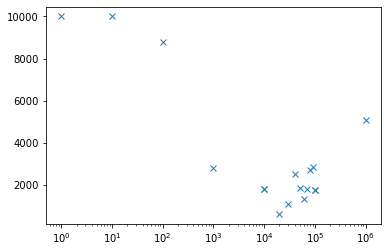

In [420]:
plt.plot(B, info['it'], 'x')
plt.xscale('log')

In [423]:
B = list(linspace(1e+4,2e+5,40))
info = {'it':[], 'dist_obj':[]}
for b in B:
    print(b)
    _, _, _, _, every_iter = accelerated_primal_dual(c+ε,m,n, 10000, collect_obj = True, 
                                                             true_obj = obj_exact+ε, true_obj_tol = 1e-7, 
                                                             true_solution = sol, save_iter = True, show = False,
                                                             δ = 0.99, μ = 0.7, λ = 0, β = b)
    info['it'].append( len(every_iter['it']) )
    info['dist_obj'].append( every_iter['dist_obj'][-1] )

10000.0
14871.794871794871
19743.589743589742
24615.384615384617
29487.17948717949
34358.97435897436
39230.769230769234
44102.5641025641
48974.35897435898
53846.15384615385
58717.94871794872
63589.74358974359
68461.53846153847
73333.33333333334
78205.1282051282
83076.92307692308
87948.71794871795
92820.51282051283
97692.3076923077
102564.10256410256
107435.89743589744
112307.69230769231
117179.48717948719
122051.28205128206
126923.07692307694
131794.8717948718
136666.6666666667
141538.46153846153
146410.2564102564
151282.05128205128
156153.84615384616
161025.64102564103
165897.4358974359
170769.23076923078
175641.02564102566
180512.82051282053
185384.6153846154
190256.41025641028
195128.20512820513
200000.0


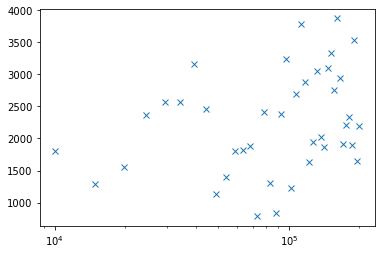

In [424]:
plt.plot(B, info['it'], 'x')
plt.xscale('log')

In [429]:
B = list(linspace(8e+4,1e+5,100))
info = {'it':[], 'dist_obj':[]}
for b in B:
    print(b)
    _, _, _, _, every_iter = accelerated_primal_dual(c+ε,m,n, 10000, collect_obj = True, 
                                                             true_obj = obj_exact+ε, true_obj_tol = 1e-7, 
                                                             true_solution = sol, save_iter = True, show = False,
                                                             δ = 0.99, μ = 0.7, λ = 0, β = b)
    info['it'].append( len(every_iter['it']) )
    info['dist_obj'].append( every_iter['dist_obj'][-1] )

80000.0
80202.0202020202
80404.04040404041
80606.06060606061
80808.0808080808
81010.101010101
81212.12121212122
81414.14141414141
81616.16161616161
81818.18181818182
82020.20202020202
82222.22222222222
82424.24242424243
82626.26262626263
82828.28282828283
83030.30303030302
83232.32323232324
83434.34343434343
83636.36363636363
83838.38383838384
84040.40404040404
84242.42424242424
84444.44444444444
84646.46464646465
84848.48484848485
85050.50505050505
85252.52525252526
85454.54545454546
85656.56565656565
85858.58585858587
86060.60606060606
86262.62626262626
86464.64646464646
86666.66666666667
86868.68686868687
87070.70707070707
87272.72727272728
87474.74747474748
87676.76767676767
87878.78787878787
88080.80808080808
88282.82828282828
88484.84848484848
88686.8686868687
88888.88888888889
89090.90909090909
89292.9292929293
89494.9494949495
89696.9696969697
89898.9898989899
90101.0101010101
90303.0303030303
90505.0505050505
90707.0707070707
90909.09090909091
91111.11111111111
91313.131313131

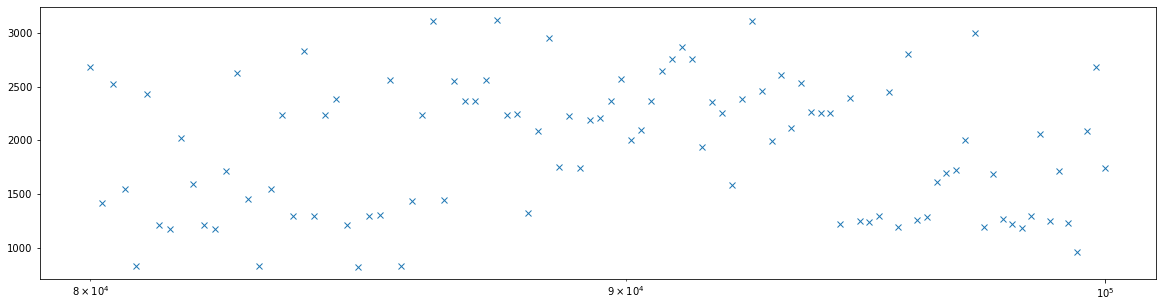

In [432]:
plt.figure(figsize = (20,5))
plt.plot(B, info['it'], 'x')
plt.xscale('log')

In [463]:
x, y, obj, every_critical, every_iter = accelerated_primal_dual(c+ε,m,n, 10000, collect_obj = True, 
                                                            true_obj = obj_exact+ε, true_obj_tol = 1e-7, 
                                                            true_solution = sol, save_iter = True, show = False,
                                                            δ = 0.99, μ = 0.7, λ = 0, β = B[np.argmin(info['it'])])

We can see that some choices of $\beta < \tau^{-2}$ yield very fast convergence. However, we still get negative entries in the result:

In [460]:
print('Positive ratio:', 100*x[x<0].size/x.size)

Positive ratio: 52.880859375


## Second choice of funcions

Even though we have some parameter choices that arrive at the correct minimal function value, the choices for $f$ and $g$ that we have taken are not enough to guarantee a feasible solution satisfying all the constraints of the problem.

Let $\mathcal{X}$ be the following set of real-valued matrices with prescribed row and column sums; i.e.,
$
    \mathcal{X} := 
    \big\{
        u \in \mathbb{R}^{M\times N}:\,   u \mathbb{1}_N = m 
        \,\,\text{ and }\,\,
        \mathbb{1}_M u = n
    \big\}
$;
where $\mathbb{1}_s$ is a vector of ones of size $s$.

Again in the framework of Malitsky and Pock (2018), we now identify $g(x) = c:x + \imath_{\mathbb{R}_{\geq 0}}(x)$, $f = \imath_{\mathcal{X}}$, and $K=\mathsf{I}_{N\times m}$. Observe that this choice does not suffer the drawbacks of a cost with some zero valued entries.

Doing this, we obtain a simplified version of APD as the linear operator is implicitly applied in $g$. This further simplifies the linesearch step, since we have to check whether $ \sqrt{\beta} \tau_k \| (y_{k+1}-y_k) \| \leq \delta \| y_{k+1}-y_k \| $ is satisfied. However, this is trivial whenever $\tau_k \leq \delta \big/ \sqrt{\beta} $. We can take two paths here, one is to saturate this constraint, which results in a slight different version of the algorithm of Bằng Công Vũ (2011) as $\mu$ and $\theta$ are avoided.

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Tight Primal Dual Algorithm with Linesearch</h2>
<ol>
<li>Set $\beta >0$, $\delta \in (0,1)$
<li>Set $\tau = \delta \big/ \sqrt{\beta} $
<li>For $k \in \{1,\ldots, K\}$, do
<ol>
<li>$x_k = \mathrm{prox}_{\tau g} \big( x_{k-1} - \tau y_k \big)$
    <li> $\bar{x}_k = 2x_k  - x_{k-1}$
    <li> $y_{k+1} = \mathrm{prox}_{ \beta\tau f^*} (y_k + \beta\tau \bar{x}_k)$

</div>

Another approach that is a middle ground between the two algorithms, is to instead keep the linesearch, but with a simplified stopping criterium:

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Simplified Primal Dual Algorithm with Linesearch</h2>
<ol>
<li>Set $\tau_0,\beta >0$, $\mu,\delta \in (0,1)$
<li>Set $\theta_0 = 1$</li>
<li>For $k \in \{1,\ldots, K\}$, do
<ol>
<li>$x_k = \mathrm{prox}_{\tau_{k-1} g} \big( x_{k-1} - \tau_{k-1} y_k \big)$
<li>Choose $\tau_k \in [\tau_{k-1}, \tau_{k-1}\sqrt{1+\theta}]$
<div style="color: #088A68;">
// Linesearch //
</div>
    <ol>
    <li> $\theta_k = {\tau_k} \big/ {\tau_{k-1}}$
    <li> $\bar{x}_k = x_k + \theta_k (x_k - x_{k-1})$
    <li> $y_{k+1} = \mathrm{prox}_{ \beta\tau_k f^*} (y_k + \beta\tau_k \bar{x}_k)$
    <li> Break linesearch if $ \sqrt{\beta} \tau_k \leq \delta $, else $\tau_k = \mu \tau_k$
    </ol>
</div>

Now, the proximity operator of $\eta g$ is just $\mathrm{prox}_{\eta g} (u) = [ u - \eta c ]_+$. Letting $u_k = x_{k-1} - \tau_{k-1} y_k$, we obtain that
\begin{align}
    x_k &= \mathrm{prox}_{\tau_{k-1} g} (u_k) = [ u_k - \tau_{k-1} c ]_+
    \\
    &= [x_{k-1} - \tau_{k-1} y_k - \tau_{k-1} c]_+ = [x_{k-1} - \tau_{k-1} (y+c) ]_+
\end{align}

Now, the proximal of $g$ is the projection on $\mathcal{X}$, which is of the form $\mathrm{proj}_{\mathcal{X}}(u) = u - G(u)$, where $G$ is known. Using again the extended Moreau decomposition (see the details in [OT - PD - Improved](OT%20-%20PD%20-%20Improved.ipynb)), we get that
\begin{align}
    y_{k+1} &= (\beta \tau_k) G\big( (\beta \tau_k)^{-1} y_k + \bar{x}_k)\big).
\end{align}
This gives rise to the following adapted algorithm:

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Primal Dual Algorithm with Linesearch</h2>
<ol>
<li>Set $\tau_0,\beta >0$, $\mu,\delta \in (0,1)$
<li>Set $\theta_0 = 1$</li>
<li>For $k \in \{1,\ldots, K\}$, do
<ol>
<li>$x_k = [x_{k-1} - \tau_{k-1} (y+c) ]_+$
<li>Choose $\tau_k \in [\tau_{k-1}, \tau_{k-1}\sqrt{1+\theta}]$
<div style="color: #088A68;">
// Linesearch //
</div>
<ol>
<li> $\theta_k = {\tau_k} \big/ {\tau_{k-1}}$
<li> $\bar{x}_k = x_k + \theta_k (x_k - x_{k-1})$
<li> $u_k = (\beta \tau_k)^{-1} y_k + \bar{x}_k$

<div style="color: #088A68;">
// Projection onto the set of real-valued matrices with prescribed row and column sums //
</div>
<li>$\kappa_1 = u_k\mathbb{1}_{N} - m$
<li>$\beta_1 = \langle \kappa_1, \mathbb{1}_M \rangle \big/ (M+N)$
<li>$\kappa_2 = \mathbb{1}_{M}u_k - n$
<li>$\beta_2 = \langle \kappa_2, \mathbb{1}_N \rangle \big/ (M+N)$
<li>$y_{k+1} = (\beta \tau_k) \big( \frac{1}{N}(\kappa_1 - \beta_1)\mathbb{1}_{N}^\top + \frac{1}{M} \mathbb{1}_{M}( \kappa_2 - \beta_2 )^\top \big) $

<div style="color: #088A68;">
// Linesearch condition //
</div>
<li> Break linesearch if $ \sqrt{\beta} \tau_k \leq \delta  $, else $\tau_k = \mu \tau_k$
    </ol>
</div>

In [476]:
def primal_dual_Ls(c,m,n,iters, collect_obj = False, true_obj = None, 
                         true_obj_tol = 1e-4, true_solution = None, save_iter = False, 
                         guess_x = None,  guess_y = None, show = False,
                         τ = 1e-3 * 1.9, σ = 1.0/(1e-3 * 1.9) - 1e-5, δ = 0.99, μ = 0.7, λ = 0.5, β = None):
    # Algorithm for calculating solution x, in the primal space
    # and y = [ψ, ϕ] in the dual space.
    # Also returns the value of the objective function c*x at each
    # iteration.
    # μ = 0.7, δ = 0.99, τ0 = \sqrt{ \min\{m,n\} }, β = 1/400, = σ/τ [PDAL]
    # μ, δ in (0,1)^2
    
    '''
        Initialise parameters
    '''
    
    # Fetch lengths of m and n
    N = n.size
    M = m.size
    
    #Initialise β
    if β is None:
        β  = σ/τ                       # Primal stepsize is updated
    sβ = β**0.5
    
    # Base parameters
    #τ = (min(M,N))**0.5            # Initial step from paper
    τₖ = 0.0                       # Updated step
    
    #Initialise θ
    θ = 1.0
    

    if show:
        print('\n*** Primal Dual with M = {}, N = {}, MN = {} ***\n\n'.format(M,N,M*N))
    
    
    '''
        Initialise matrices
    '''
    # Initialise x & y
    if guess_x is not None:
        x = guess_x.copy()
    elif guess_y is not None:
        ψ, ϕ = y.copy()
    else:
        x = zeros((M,N));
        ϕ = zeros(M);
        ψ = zeros(N);
        
    # Initialise p, y, u, κ
    κₘ, yₘ = zeros((2,M))
    κₙ, yₙ = zeros((2,N))
    p, u = ones((2,M,N));
    # Initialise previous copy of x
    xₚ = x.copy()
        
    '''
        Information from true solution (if available)
    '''
    # Store current objective value
    if collect_obj == True:
        obj = [ (c*x).sum() ]
    
    # Norm of true solution
    if true_solution is not None:
        true_obj_crit = 1.0
        if true_obj is None:
            true_obj = (c*sol).sum()
        if show:
            print('Objective from ground truth:', obj_exact,'\n')
            
        
    '''
        Iterate the Primal Dual scheme
    '''
    every_iter = {
        'it':[], 'obj':[], 'dist_obj':[], 'time':[], 'dist_x':[], 'rel_var':[], 'l_1':[],
        'hyperₘ':{'L2': [], 'max': [], 'min':[]}, 'hyperₙ':{'L2': [], 'max': [], 'min':[]}
                 }
    every_critical = {'it':[], 'obj':[], 'tol':[], 'dist_obj':[], 'time':[], 'dist_x':[], 'l_1':[]}
    
    if true_solution is not None:
        if show:
            print('     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  ')
            print( '{:-^66}'.format('') )
        
    timed = 0.0
    
    
    for k in range(iters):
        it_time = time.time()
        
        # ** Primal step ** #
        # p = x - τ * (c + y)
        add(c,ψ, out=p);    add(p,ϕ.reshape(M,1), out=p);    subtract(x, τ*p, out=p)
        # [p]_+
        maximum(p, 0.0, p)
        
        # ** Select extreme ** #
        #τₖ = τ * (1 + θ)**0.5                # From paper
        #τₖ = 0.5 * τ * (1 + (1 + θ)**0.5)    # From Pete
        τₖ = τ * (λ + (1-λ) * (1 + θ)**0.5 )
        
        # ** Dual step ** #
        while True:
            θ = τₖ/τ
            σ = β * τₖ
            
            # x̄ = (1+θ)*p - θ*x
            # u = y/σ + x̄
            subtract( (1+θ)*p, θ*x, out=u);    add(u,ψ/σ, out=u);    add(u,ϕ.reshape(M,1)/σ, out=u)
            
            # Projection step
            κₘ = u.sum(1) - m
            κₙ = u.sum(0) - n

            βₘ = κₘ.sum() / (M + N)        # dim M
            βₙ = κₙ.sum() / (M + N)        # dim N

            # Implicit yₖ = ( (κₘ - βₘ)*σ/N).reshape(M,1) + σ*(κₙ - βₙ)/M
            ϕ = (σ/N) * (κₘ - βₘ)
            ψ = (σ/M) * (κₙ - βₙ)
        
            # Linesearch stopping criterium
            if (sβ * τₖ < δ):
                break
            # Else: reduce step size
            τₖ *= μ
        
        τ = τₖ
        x = p.copy()
        
        
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time
        
        # Recover values from mask
        ℓ_1 = norm(x.ravel(),1)
        
        # Update objective function
        if collect_obj == True:
            obj.append( (c*x).sum() )
            # Compute relative objective distance
            if true_solution is not None:
                dist_true_sol = abs(obj[-1] - true_obj)/true_obj
                
                
        # If all iterations are to be stored:
        if save_iter == True:
            frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
            r, s   = x.sum(1) - m, x.sum(0) - n
            
            every_iter['it'].append( k )
            every_iter['obj'].append( (c*x).sum() )
            every_iter['dist_obj'].append( dist_true_sol if true_obj is not None else np.nan )
            every_iter['time'].append( timed )
            every_iter['dist_x'].append( frob_d )
            every_iter['rel_var'].append( norm(xₚ-x, 'fro')/norm(x, 'fro') if not allclose(x,0) else np.nan )
            every_iter['l_1'].append(ℓ_1)
            # Constrained satisfactibility
            every_iter['hyperₘ']['L2'].append( norm(r)/norm(m) )
            every_iter['hyperₘ']['max'].append( abs(r/maximum(m,1e-7)).max() )
            every_iter['hyperₘ']['min'].append( abs(r/maximum(m,1e-7)).min() )
            every_iter['hyperₙ']['L2'].append( norm(s)/norm(n) )
            every_iter['hyperₙ']['max'].append( abs(s/maximum(n,1e-7)).max() )
            every_iter['hyperₙ']['min'].append( abs(s/maximum(n,1e-7)).min() )
            
        # If a true solution is available, we check the tolerance:
        if true_solution is not None: 
            if dist_true_sol < true_obj_crit:
                frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
                
                every_critical['it'].append( k )
                every_critical['obj'].append( obj[-1] )
                every_critical['tol'].append( true_obj_crit )
                every_critical['dist_obj'].append( dist_true_sol )
                every_critical['time'].append( timed )
                every_critical['dist_x'].append( frob_d )
                every_critical['l_1'].append(ℓ_1)

                if show:
                    print('* {0:6.0f} |   {1:.1e} |  {2:1.1e}  | {3:8.2f} s |   {4:4.4f} |  {5:4.4f}'.format(k,
                                                                            true_obj_crit,
                                                                            dist_true_sol,
                                                                            timed,frob_d,ℓ_1))
                
                # If the prescribed tolerance is reached, we finish.
                if dist_true_sol < true_obj_tol:
                    if show:
                        print('Solution found with given tolerance.')
                    break
                
                # Adjust current level of inner tolerance
                true_obj_crit *= 0.1
        
        # Update previous step
        xₚ = x.copy()
    
    if true_solution is not None:
        if show:
            print( '{:-^66}'.format('') )

    if show:
        print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(timed,k))
    
    y = asarray([ψ, ϕ],dtype='object')
    
    if collect_obj == False and save_iter == True:
        return x, y, every_iter
    if collect_obj == True and save_iter == True:
        return x, y, obj, every_critical, every_iter
    else:
        return x

In [477]:
x, y, obj, every_critical, every_iter = primal_dual_Ls(c,m,n, 10000, collect_obj = True, 
                                                             true_obj = obj_exact, true_obj_tol = 1e-7, 
                                                             true_solution = sol, save_iter = True, 
                                                                show = True, δ=0.9, μ=0.9)


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      2 |   1.0e+00 |  1.3e-01  |     0.00 s |   0.9892 |  0.2304
*      8 |   1.0e-01 |  1.0e-01  |     0.00 s |   0.9706 |  0.2873
*    477 |   1.0e-02 |  8.1e-03  |     0.05 s |   0.4975 |  0.9539
*    577 |   1.0e-03 |  5.0e-04  |     0.06 s |   0.4818 |  0.9590
*   2802 |   1.0e-04 |  5.9e-05  |     0.21 s |   0.3349 |  1.0001
*   2803 |   1.0e-05 |  8.1e-06  |     0.21 s |   0.3349 |  1.0001
*   3465 |   1.0e-06 |  6.7e-07  |     0.25 s |   0.3333 |  1.0000
*   4793 |   1.0e-07 |  1.1e-08  |     0.34 s |   0.3333 |  1.0000
Solution found with given tolerance.
------------------------------------------------------------------

Algorithm stopped after 0.3396 seconds and 4793 iterations


Let us repeat some of the experiments we did above:

In [480]:
ε = 1.0
x, y, obj, every_critical, every_iter = primal_dual_Ls(c+ε,m,n, 10000, collect_obj = True, 
                                                             true_obj = obj_exact+ε, true_obj_tol = 1e-7, 
                                                             true_solution = sol, save_iter = True, show = True,
                                                             δ = 0.99, μ = 0.7, λ = 0)


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      1 |   1.0e+00 |  9.9e-01  |     0.00 s |   0.9982 |  0.0124
*      4 |   1.0e-01 |  6.6e-02  |     0.00 s |   0.9448 |  0.9448
*     28 |   1.0e-02 |  6.0e-03  |     0.01 s |   0.8317 |  0.9794
*    450 |   1.0e-03 |  1.0e-03  |     0.04 s |   0.4120 |  1.0000
*    935 |   1.0e-04 |  9.5e-05  |     0.06 s |   0.3370 |  0.9999
*   1257 |   1.0e-05 |  9.0e-06  |     0.08 s |   0.3221 |  1.0000
*   1261 |   1.0e-06 |  4.1e-07  |     0.08 s |   0.3220 |  1.0000
*   1729 |   1.0e-07 |  9.7e-09  |     0.10 s |   0.3160 |  1.0000
Solution found with given tolerance.
------------------------------------------------------------------

Algorithm stopped after 0.1029 seconds and 1729 iterations


In [483]:
x, y, obj, every_critical, every_iter = primal_dual_Ls(c+ε,m,n, 10000, collect_obj = True, 
                                                             true_obj = obj_exact+ε, true_obj_tol = 1e-7, 
                                                             true_solution = sol, save_iter = True, show = True,
                                                             δ = 0.99, μ = 0.7, λ = 0, β = 1e+5)


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      2 |   1.0e+00 |  1.0e+00  |     0.00 s |   1.0000 |  0.0002
*     14 |   1.0e-01 |  9.2e-02  |     0.00 s |   0.8589 |  0.8766
*     24 |   1.0e-02 |  5.6e-03  |     0.01 s |   0.8019 |  0.9714
*    257 |   1.0e-03 |  9.5e-04  |     0.02 s |   0.4209 |  0.9998
*    489 |   1.0e-04 |  9.8e-05  |     0.04 s |   0.3466 |  1.0000
*    494 |   1.0e-05 |  3.3e-06  |     0.04 s |   0.3459 |  0.9999
*    496 |   1.0e-06 |  2.0e-07  |     0.04 s |   0.3456 |  0.9999
*   1179 |   1.0e-07 |  6.1e-08  |     0.07 s |   0.3170 |  1.0000
Solution found with given tolerance.
------------------------------------------------------------------

Algorithm stopped after 0.0723 seconds and 1179 iterations


In [490]:
print('Average time per iteration:',every_iter['time'][-1]/len(every_iter['time']))

Average time per iteration: 6.126912973694882e-05


In [571]:
γ = 2            # 2 less iterations
γ = 3            # 360 l.i. (< 1e+4)
γ = 5            # 576 l.i.
x, y, obj, every_critical, every_iter = primal_dual_Ls( γ*(c+ε),m,n, 10000, collect_obj = True, 
                                                             true_obj = γ*(obj_exact+ε), true_obj_tol = 1e-7, 
                                                             true_solution = sol, save_iter = True, show = True,
                                                             δ = 0.99, μ = 0.7, λ = 0, β = 1e+5)


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      8 |   1.0e+00 |  9.9e-01  |     0.00 s |   1.0002 |  0.0063
*     84 |   1.0e-01 |  1.0e-01  |     0.01 s |   0.4605 |  0.8971
*    140 |   1.0e-02 |  1.0e-02  |     0.01 s |   0.3737 |  0.9878
*    163 |   1.0e-03 |  9.4e-04  |     0.01 s |   0.3528 |  0.9982
*    201 |   1.0e-04 |  3.1e-05  |     0.02 s |   0.3317 |  1.0003
*    344 |   1.0e-05 |  8.6e-06  |     0.02 s |   0.3190 |  1.0002
*    485 |   1.0e-06 |  6.3e-07  |     0.03 s |   0.3179 |  1.0001
*    601 |   1.0e-07 |  7.3e-08  |     0.04 s |   0.3180 |  1.0000
Solution found with given tolerance.
------------------------------------------------------------------

Algorithm stopped after 0.0372 seconds and 601 iterations


We have guaranteed that $x$ is positive, but now $x$ does not satisfy all the constraints:

In [568]:
norm(x.sum(1) - m), norm(x.sum(0) - n)

(0.00022384770369041648, 0.0002753765820328536)

Let's do some additional tests:

In [578]:
B = list(linspace(9e+4,2e+5,50))
info = {'it':[], 'dist_obj':[]}
for b in B:
    #print(b)
    _, _, _, _, every_iter = primal_dual_Ls( γ*(c+ε),m,n, 10000, collect_obj = True, 
                                                             true_obj = γ*(obj_exact+ε), true_obj_tol = 1e-7, 
                                                             true_solution = sol, save_iter = True, show = False,
                                                             δ = 0.99, μ = 0.7, λ = 0, β = b)
    info['it'].append( len(every_iter['it']) )
    info['dist_obj'].append( every_iter['dist_obj'][-1] )

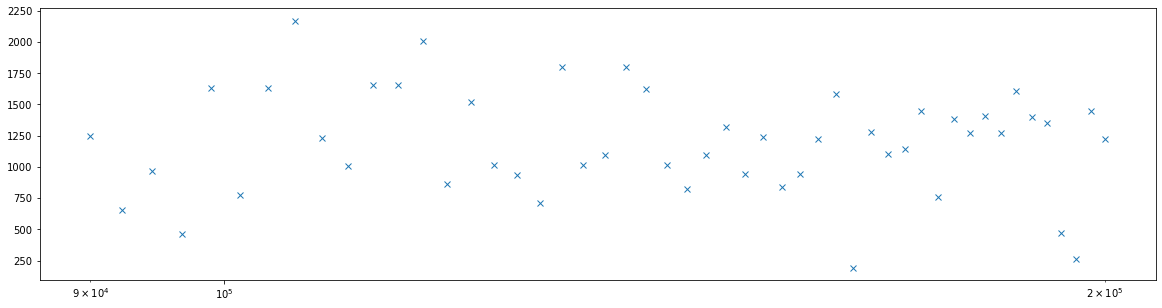

In [579]:
plt.figure(figsize = (20,5))
plt.plot(B, info['it'], 'x')
plt.xscale('log')

In [581]:
x, y, obj, every_critical, every_iter = primal_dual_Ls( γ*(c+ε),m,n, 10000, collect_obj = True, 
                                                             true_obj = γ*(obj_exact+ε), true_obj_tol = 1e-7, 
                                                             true_solution = sol, save_iter = True, show = True,
                                                             δ = 0.99, μ = 0.7, λ = 0, β = B[np.argmin(info['it'])])


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      7 |   1.0e+00 |  1.0e+00  |     0.00 s |   1.0000 |  0.0020
*     68 |   1.0e-01 |  9.9e-02  |     0.01 s |   0.5193 |  0.8965
*    102 |   1.0e-02 |  9.9e-03  |     0.01 s |   0.4275 |  0.9870
*    129 |   1.0e-03 |  8.6e-04  |     0.01 s |   0.3890 |  0.9982
*    130 |   1.0e-04 |  8.8e-05  |     0.01 s |   0.3880 |  0.9991
*    192 |   1.0e-05 |  9.6e-08  |     0.01 s |   0.3393 |  1.0002
Solution found with given tolerance.
------------------------------------------------------------------

Algorithm stopped after 0.0132 seconds and 192 iterations


What happens if we take even more iterations?

In [598]:
x, y, obj, every_critical, every_iter = primal_dual_Ls( γ*(c+ε),m,n, 10000, collect_obj = True, 
                                                             true_obj = γ*(obj_exact+ε), true_obj_tol = 1e-10, 
                                                             true_solution = sol, save_iter = True, show = True,
                                                             δ = 0.99, μ = 0.7, λ = 0, β = B[np.argmin(info['it'])])


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      7 |   1.0e+00 |  1.0e+00  |     0.00 s |   1.0000 |  0.0020
*     68 |   1.0e-01 |  9.9e-02  |     0.01 s |   0.5193 |  0.8965
*    102 |   1.0e-02 |  9.9e-03  |     0.01 s |   0.4275 |  0.9870
*    129 |   1.0e-03 |  8.6e-04  |     0.02 s |   0.3890 |  0.9982
*    130 |   1.0e-04 |  8.8e-05  |     0.02 s |   0.3880 |  0.9991
*    192 |   1.0e-05 |  9.6e-08  |     0.02 s |   0.3393 |  1.0002
*    842 |   1.0e-06 |  6.6e-07  |     0.06 s |   0.3228 |  1.0000
*   1120 |   1.0e-07 |  4.6e-09  |     0.08 s |   0.3228 |  1.0000
*   3416 |   1.0e-08 |  9.0e-09  |     0.21 s |   0.3227 |  1.0000
*   4217 |   1.0e-09 |  8.4e-10  |     0.25 s |   0.3227 |  1.0000
*   4550 |   1.0e-10 |  1.4e-11  |     0.27 s |   0.3227 |  1.0000
Solution found with gi

In [599]:
norm(x.sum(1) - m), norm(x.sum(0) - n)

(5.8820130006804184e-08, 5.613996700292183e-08)

We can even reach **under** the support…

In [603]:
x[x==0.0].size, sol[sol==0.0].size

(3879, 3969)

---

In [643]:
x, y, obj, every_critical, every_iter = primal_dual_Ls( γ*(c+ε),m,n, 15000, collect_obj = True, 
                                                             true_obj = γ*(obj_exact+ε), true_obj_tol = 1e-18, 
                                                             true_solution = sol, save_iter = True, show = True,
                                                             δ = 0.99, μ = 0.7, λ = 0, β = B[np.argmin(info['it'])])


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      7 |   1.0e+00 |  1.0e+00  |     0.00 s |   1.0000 |  0.0020
*     68 |   1.0e-01 |  9.9e-02  |     0.01 s |   0.5193 |  0.8965
*    102 |   1.0e-02 |  9.9e-03  |     0.01 s |   0.4275 |  0.9870
*    129 |   1.0e-03 |  8.6e-04  |     0.02 s |   0.3890 |  0.9982
*    130 |   1.0e-04 |  8.8e-05  |     0.02 s |   0.3880 |  0.9991
*    192 |   1.0e-05 |  9.6e-08  |     0.02 s |   0.3393 |  1.0002
*    842 |   1.0e-06 |  6.6e-07  |     0.06 s |   0.3228 |  1.0000
*   1120 |   1.0e-07 |  4.6e-09  |     0.08 s |   0.3228 |  1.0000
*   3416 |   1.0e-08 |  9.0e-09  |     0.21 s |   0.3227 |  1.0000
*   4217 |   1.0e-09 |  8.4e-10  |     0.25 s |   0.3227 |  1.0000
*   4550 |   1.0e-10 |  1.4e-11  |     0.27 s |   0.3227 |  1.0000
*   6882 |   1.0e-11 |

Observe that we have reached the minimal value!

In [658]:
r, s = x.sum(1) - m, x.sum(0) - n

In [715]:
# Print error estimates
print('ℓ-error | r = x 𝟙ₙ - m |      r/m     | s = 𝟙ₘ x - n |      s/n ')
print( '{:-^67}'.format('') )
print('   1    | {0:1.6e} | {1:1.6e} | {2:1.6e} | {3:1.6e} '.format(
            norm(r,1), norm(r/maximum(m,1e-7),1), norm(s,1), norm(s/maximum(n,1e-7),1) ))
print('   2    | {0:1.6e} | {1:1.6e} | {2:1.6e} | {3:1.6e} '.format(
                            norm(r), norm(r/maximum(m,1e-7)), norm(s), norm(s/maximum(n,1e-7)) ))
print('   ∞    | {0:1.6e} | {1:1.6e} | {2:1.6e} | {3:1.6e} '.format(
            norm(r,np.inf), norm(r/maximum(m,1e-7),np.inf), norm(s,np.inf), norm(s/maximum(n,1e-7),np.inf) ))
print('  -∞    | {0:1.6e} | {1:1.6e} | {2:1.6e} | {3:1.6e} '.format(
            abs(r).min(), abs(r/maximum(m,1e-7)).min(), abs(s).min(), abs(s/maximum(m,1e-7)).min() ))
print( '{:-^67}'.format('') )

ℓ-error | r = x 𝟙ₙ - m |      r/m     | s = 𝟙ₘ x - n |      s/n 
-------------------------------------------------------------------
   1    | 7.319145e-14 | 1.130113e-11 | 6.530974e-14 | 7.611514e-12 
   2    | 1.142117e-14 | 2.539257e-12 | 1.069473e-14 | 1.568626e-12 
   ∞    | 3.123803e-15 | 1.446959e-12 | 2.962908e-15 | 6.049050e-13 
  -∞    | 0.000000e+00 | 0.000000e+00 | 1.734723e-18 | 1.853598e-16 
-------------------------------------------------------------------


We can even reach **under** the support…

In [645]:
x[x==0.0].size, sol[sol==0.0].size

(3879, 3969)

Running for 30000 iterations, we get tolerances of 9.9e-324 (21366) and the following result:
```
ℓ-error | r = x 𝟙ₙ - m |      r/m     | s = 𝟙ₘ x - n |      s/n 
-------------------------------------------------------------------
   1    | 2.832803e-15 | 3.117459e-13 | 2.605555e-15 | 2.475104e-13 
   2    | 4.423800e-16 | 5.974417e-14 | 4.017393e-16 | 4.385313e-14 
   ∞    | 1.474515e-16 | 2.267641e-14 | 1.179612e-16 | 1.735443e-14 
  -∞    | 8.673617e-19 | 1.414873e-16 | 0.000000e+00 | 0.000000e+00 
-------------------------------------------------------------------
```

---

The constraints are not satisfied with the same numerical tolerance as the base solution though:

In [716]:
r, s = sol.sum(1) - m, sol.sum(0) - n

In [722]:
# Print error estimates
print('ℓ-error | r = x̄ 𝟙ₙ - m |      r/m     | s = 𝟙ₘ x̄ - n |      s/n ')
print( '{:-^67}'.format('') )
print('   1    | {0:1.6e} | {1:1.6e} | {2:1.6e} | {3:1.6e} '.format(
            norm(r,1), norm(r/maximum(m,1e-7),1), norm(s,1), norm(s/maximum(n,1e-7),1) ))
print('   2    | {0:1.6e} | {1:1.6e} | {2:1.6e} | {3:1.6e} '.format(
                            norm(r), norm(r/maximum(m,1e-7)), norm(s), norm(s/maximum(n,1e-7)) ))
print('   ∞    | {0:1.6e} | {1:1.6e} | {2:1.6e} | {3:1.6e} '.format(
            norm(r,np.inf), norm(r/maximum(m,1e-7),np.inf), norm(s,np.inf), norm(s/maximum(n,1e-7),np.inf) ))
print('  -∞    | {0:1.6e} | {1:1.6e} | {2:1.6e} | {3:1.6e} '.format(
            abs(r).min(), abs(r/maximum(m,1e-7)).min(), abs(s).min(), abs(s/maximum(m,1e-7)).min() ))
print( '{:-^67}'.format('') )

ℓ-error | r = x̄ 𝟙ₙ - m |      r/m     | s = 𝟙ₘ x̄ - n |      s/n 
-------------------------------------------------------------------
   1    | 7.979728e-17 | 2.447586e-15 | 1.908196e-17 | 6.651720e-16 
   2    | 5.663812e-17 | 1.593472e-15 | 9.341772e-18 | 2.990516e-16 
   ∞    | 5.551115e-17 | 1.550475e-15 | 6.938894e-18 | 1.558086e-16 
  -∞    | 0.000000e+00 | 0.000000e+00 | 0.000000e+00 | 0.000000e+00 
-------------------------------------------------------------------


## Visualise and store results

In [434]:
main_folder = folder + '_Results'
out_folder  = main_folder + '/' + instance
algorithm   = 'APD-'

In [435]:
# Check if main folder for results exists, else create it
if not os.path.exists(main_folder):    os.makedirs(main_folder)
# Now create a folder for the results of the instance
if not os.path.exists(out_folder):    os.makedirs(out_folder)
out_folder += '/' + algorithm

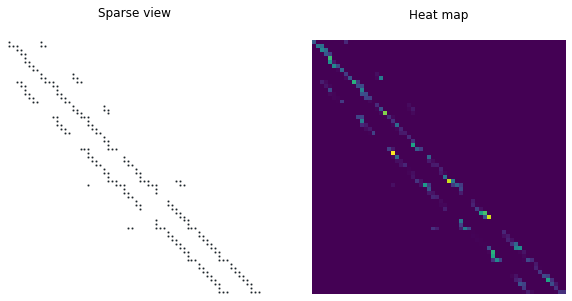

In [631]:
# Visualise solution
plt.figure(figsize = (10,5))

plt.subplot(1, 2, 1)
plt.spy(x, markersize=1, aspect = 1, markeredgecolor = 'black', alpha=0.75);    plt.axis('off')
plt.title('Sparse view')
plt.subplot(1, 2, 2)
plt.imshow(x);    plt.axis('off');    plt.title('Heat map\n')

#plt.savefig(out_folder+'Sparse-Heat.pdf', bbox_inches='tight',transparent=True)
plt.show()

In [632]:
if 'γ' not in locals():
    γ = 1

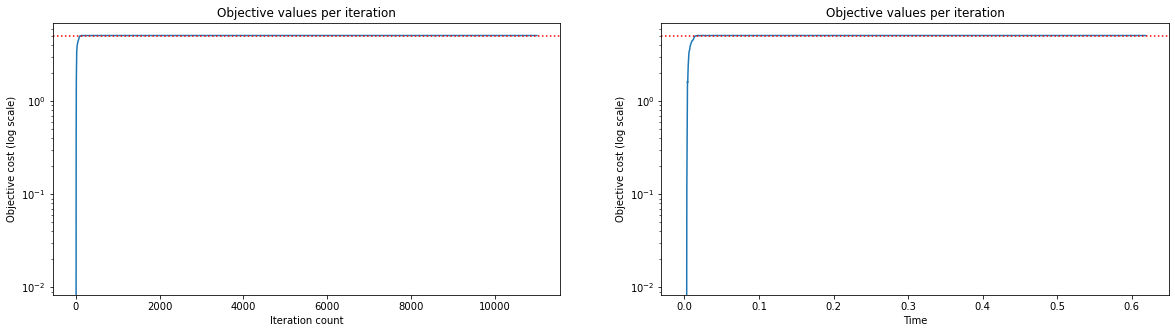

In [633]:
# Visualise evolution of objective values
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(obj)
plt.axhline(y=γ*(obj_exact+ε), color='r', linestyle=':')
plt.yscale('log');    plt.title('Objective values per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Objective cost (log scale)')
plt.subplot(1, 2, 2)
plt.plot(np.append([0], every_iter['time']),obj)
plt.axhline(y=γ*(obj_exact+ε), color='r', linestyle=':')
plt.yscale('log')
plt.title('Objective values per iteration')
plt.xlabel('Time');    plt.ylabel('Objective cost (log scale)')

#plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.show()

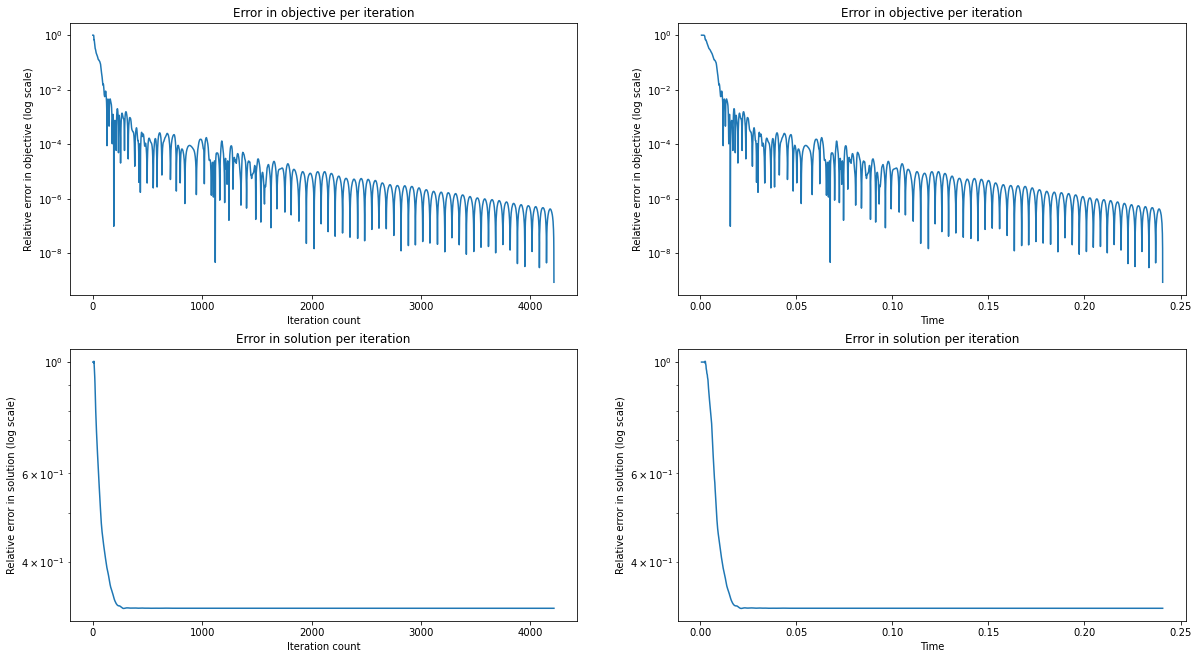

In [592]:
# Visualise evolution of relative errors
plt.figure(figsize = (20,11))

plt.subplot(2, 2, 1)
plt.plot(every_iter['dist_obj'])
plt.yscale('log')
plt.title('Error in objective per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Relative error in objective (log scale)')
plt.subplot(2, 2, 2)
plt.plot(every_iter['time'],every_iter['dist_obj'])
plt.yscale('log')
plt.title('Error in objective per iteration')
plt.xlabel('Time');    plt.ylabel('Relative error in objective (log scale)')
plt.subplot(2, 2, 3)
plt.plot(every_iter['dist_x'])
plt.yscale('log')
plt.title('Error in solution per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Relative error in solution (log scale)')
plt.subplot(2, 2, 4)
plt.plot(every_iter['time'],every_iter['dist_x'])
plt.yscale('log')
plt.title('Error in solution per iteration')
plt.xlabel('Time');    plt.ylabel('Relative error in solution (log scale)')

#plt.savefig(out_folder+'Rel_Error.pdf', bbox_inches='tight',transparent=True)
plt.show()

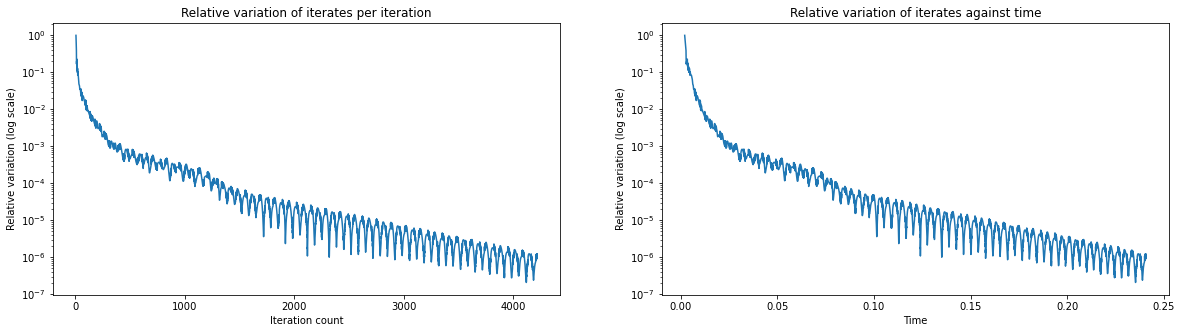

In [593]:
# Relative variation
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['it'], every_iter['rel_var'])
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative variation (log scale)');
plt.title('Relative variation of iterates per iteration')

plt.subplot(1, 2, 2)
plt.plot(every_iter['time'], every_iter['rel_var'])
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative variation (log scale)');
plt.title('Relative variation of iterates against time')

#plt.savefig(out_folder+'Relative_Var.pdf', bbox_inches='tight',transparent=True)
plt.show()

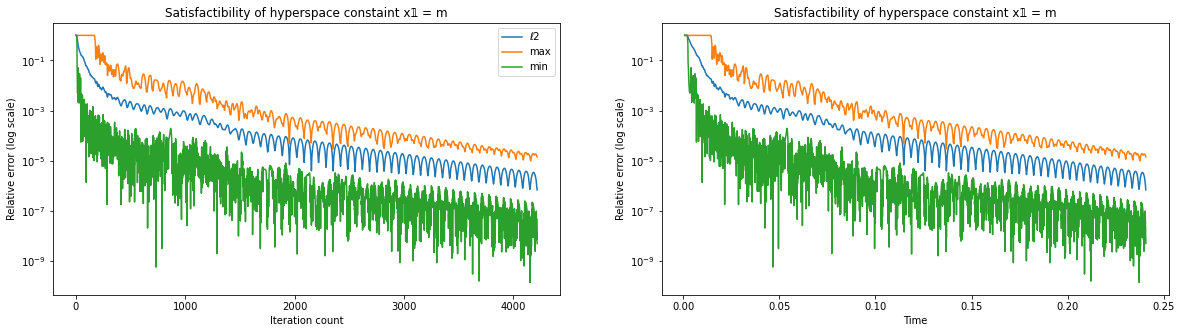

In [594]:
# Relative variation for x𝟙 = m
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['it'], every_iter['hyperₘ']['L2'], label='ℓ2')
plt.plot(every_iter['it'], every_iter['hyperₘ']['max'], label='max')
plt.plot(every_iter['it'], every_iter['hyperₘ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint x𝟙 = m')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(every_iter['time'], every_iter['hyperₘ']['L2'], label='ℓ2')
plt.plot(every_iter['time'], every_iter['hyperₘ']['max'], label='max')
plt.plot(every_iter['time'], every_iter['hyperₘ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint x𝟙 = m')

#plt.savefig(out_folder+'RelE_m.pdf', bbox_inches='tight',transparent=True)
plt.show()

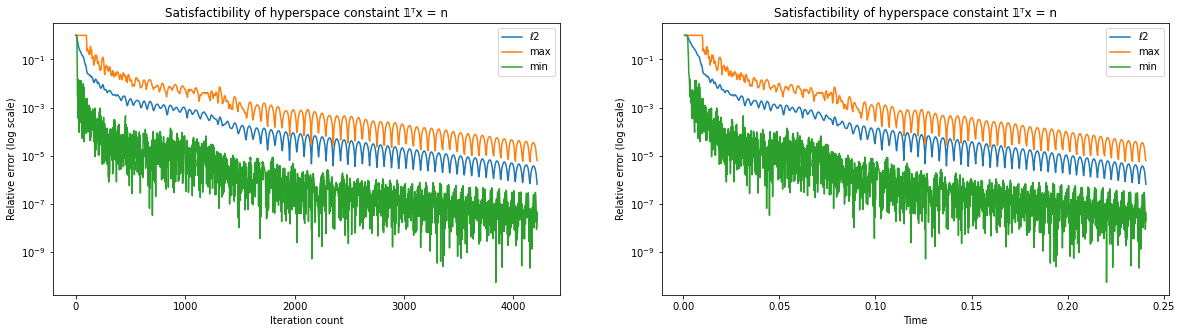

In [595]:
# Relative variation for 𝟙ᵀx = n
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['it'], every_iter['hyperₙ']['L2'], label='ℓ2')
plt.plot(every_iter['it'], every_iter['hyperₙ']['max'], label='max')
plt.plot(every_iter['it'], every_iter['hyperₙ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint 𝟙ᵀx = n');    plt.legend()

plt.subplot(1, 2, 2)
plt.plot(every_iter['time'], every_iter['hyperₙ']['L2'], label='ℓ2')
plt.plot(every_iter['time'], every_iter['hyperₙ']['max'], label='max')
plt.plot(every_iter['time'], every_iter['hyperₙ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint 𝟙ᵀx = n');    plt.legend()

#plt.savefig(out_folder+'RelE_n.pdf', bbox_inches='tight',transparent=True)
plt.show()

All the data from the above two plots is also available as dataframes:

In [27]:
df_critical = pd.DataFrame.from_dict(every_critical)
df_critical.to_pickle(out_folder+'Critical.pkl') # To read back use pd.read_pickle(file_name)
df_critical.to_excel(out_folder+'Critical.xlsx')
display(df_critical)

# If we want this table in LaTeX format run:
print(df_critical.to_latex(index=False))

,it,obj,tol,dist_obj,time,dist_x
0,20,0.004110,1.000000e+00,7.473931e-01,0.022442,0.817720
1,26,0.016258,1.000000e-01,8.445832e-04,0.028266,0.794347
2,750,0.016434,1.000000e-02,9.973055e-03,0.206107,0.334176
3,1071,0.016287,1.000000e-03,9.488914e-04,0.274810,0.316428
4,1080,0.016273,1.000000e-04,9.637775e-05,0.277153,0.316028
5,1081,0.016272,1.000000e-05,8.254818e-07,0.277492,0.315986
6,1833,0.016272,1.000000e-06,8.186380e-07,0.435859,0.312720
7,8140,0.016272,1.000000e-07,5.025872e-08,1.767318,0.312720


\begin{tabular}{rrrrrr}
\toprule
  it &      obj &          tol &     dist\_obj &     time &   dist\_x \\
\midrule
  20 & 0.004110 & 1.000000e+00 & 7.473931e-01 & 0.022442 & 0.817720 \\
  26 & 0.016258 & 1.000000e-01 & 8.445832e-04 & 0.028266 & 0.794347 \\
 750 & 0.016434 & 1.000000e-02 & 9.973055e-03 & 0.206107 & 0.334176 \\
1071 & 0.016287 & 1.000000e-03 & 9.488914e-04 & 0.274810 & 0.316428 \\
1080 & 0.016273 & 1.000000e-04 & 9.637775e-05 & 0.277153 & 0.316028 \\
1081 & 0.016272 & 1.000000e-05 & 8.254818e-07 & 0.277492 & 0.315986 \\
1833 & 0.016272 & 1.000000e-06 & 8.186380e-07 & 0.435859 & 0.312720 \\
8140 & 0.016272 & 1.000000e-07 & 5.025872e-08 & 1.767318 & 0.312720 \\
\bottomrule
\end{tabular}



In [28]:
#df_every = pd.DataFrame.from_dict(every_iter)
df_every = pd.concat([
                pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['hyperₘ', 'hyperₙ'] } ),
                pd.DataFrame.from_dict( {'hyperₘ-'+a:b for a,b in every_iter['hyperₘ'].items()} ), 
                pd.DataFrame.from_dict( {'hyperₙ-'+a:b for a,b in every_iter['hyperₙ'].items()} )], axis = 1)
df_every.to_pickle(out_folder+'Every.pkl') # To read back use pd.read_pickle(file_name)
df_every.to_excel(out_folder+'Every.xlsx')
display(df_every.head())

,it,obj,dist_obj,time,dist_x,rel_var,hyperₘ-L2,hyperₘ-max,hyperₘ-min,hyperₙ-L2,hyperₙ-max,hyperₙ-min
0,0,0.000000,1.000000,0.002334,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1,0.429072,25.369015,0.005888,0.995409,1.000000,1.369699,2.036308,0.086689,1.384806,1.797270,0.029731
2,2,-0.122430,8.524029,0.006889,0.979066,1.993502,1.351193,2.624691,0.019698,1.221135,1.815521,0.016050
3,3,0.315424,18.384654,0.007590,0.955147,1.102713,1.272243,2.449062,0.175094,1.032333,1.775681,0.144847
4,4,-0.105567,7.487717,0.008280,0.933202,1.547589,1.047288,2.180295,0.005290,0.730081,1.312823,0.002928


In [29]:
df_every.describe()

,it,obj,dist_obj,time,dist_x,rel_var,hyperₘ-L2,hyperₘ-max,hyperₘ-min,hyperₙ-L2,hyperₙ-max,hyperₙ-min
count,8141.000000,8141.000000,8.141000e+03,8141.000000,8141.000000,8140.000000,8141.000000,8141.000000,8.141000e+03,8141.000000,8141.000000,8.141000e+03
mean,4070.000000,0.016630,3.266865e-02,0.906891,0.326913,0.002196,0.002282,0.007532,2.244248e-04,0.001933,0.005606,2.315200e-04
std,2350.248604,0.007751,4.757392e-01,0.495822,0.059895,0.042102,0.039335,0.074004,1.148938e-02,0.033217,0.051377,1.143053e-02
min,0.000000,-0.122430,5.025872e-08,0.002334,0.312720,0.000002,0.000005,0.000045,1.796353e-11,0.000006,0.000057,2.170873e-11
25%,2035.000000,0.016268,1.458758e-04,0.478909,0.312720,0.000029,0.000062,0.000876,5.813902e-07,0.000061,0.000467,5.942042e-07
50%,4070.000000,0.016273,2.904957e-04,0.908676,0.312721,0.000043,0.000090,0.001448,1.573898e-06,0.000087,0.000726,1.753926e-06
75%,6105.000000,0.016278,5.209601e-04,1.334624,0.312721,0.000077,0.000151,0.002440,3.634236e-06,0.000167,0.001495,4.342418e-06
max,8140.000000,0.429072,2.536901e+01,1.767318,1.000000,1.993502,1.369699,2.624691,1.000000e+00,1.384806,1.815521,1.000000e+00


In [30]:
# Finally, store the latest solution:
np.save(out_folder + '_Sol.npy' , x)            # To read back just run:   np.load(outfile)

---
Code used to do performance tests in each piece of code:
```Python
start = time.time()
# ...
end = time.time()
print(end-start)

%timeit -r 10 -n 200 `function(x)`
```

Not much of a speedup for interpolation:
```Python
@jit(nopython=True, fastmath = True)
def interp(xₖ,x, yₖ,y, ρ):
    return ρ*xₖ + (1 - ρ)*x, ρ*yₖ + (1 - ρ)*y

xₖ, yₖ, x, y = ones((4,M,N)); ρ = 1.9
interp(xₖ,x, yₖ,y, ρ); # Run it once
```

---